# Customer Support Utterance Clustering Analysis

**Dataset:** `bitext/Bitext-customer-support-llm-chatbot-training-dataset`  
**Source:** HuggingFace Datasets Hub

---

## Pipeline

| Step | What | Tool |
|------|------|------|
| 1 | **Embed** utterances | `all-MiniLM-L6-v2` (384-dim sentence transformer) |
| 2 | **Cluster** with HDBSCAN | UMAP reduction → HDBSCAN (no need to pre-specify *k*) |
| 3 | **Evaluate** against ground-truth | ARI & NMI vs `intent` (27 classes) and `category` (11 classes) |
| 4 | **Label** clusters post-hoc | TF-IDF top terms + optional LLM labeling |

## 1. Setup & Imports

In [1]:
# All dependencies are managed via pyproject.toml + uv
# To install/sync:  uv sync
# To register the Jupyter kernel:
#   uv run python -m ipykernel install --user --name contact-center --display-name "Contact Center (Python 3.13)"
# Then select the "Contact Center (Python 3.13)" kernel in Jupyter.

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (12, 6)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("All libraries loaded.")

## 2. Load Data

In [3]:
dataset = load_dataset(
    "bitext/Bitext-customer-support-llm-chatbot-training-dataset",
    split="train"
)
df = dataset.to_pandas()
print(f"Loaded {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"Categories: {df['category'].nunique()}  |  Intents: {df['intent'].nunique()}")
df.head(3)

Loaded 26,872 rows, 5 columns
Categories: 11  |  Intents: 27


,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...


In [4]:
# Encode ground-truth labels as integers for metric computation
le_intent = LabelEncoder()
le_category = LabelEncoder()
df["intent_label"] = le_intent.fit_transform(df["intent"])
df["category_label"] = le_category.fit_transform(df["category"])

print("Ground-truth label encoding:")
print(f"  intent_label:   {df['intent_label'].nunique()} unique values (0–{df['intent_label'].max()})")
print(f"  category_label: {df['category_label'].nunique()} unique values (0–{df['category_label'].max()})")

Ground-truth label encoding:
  intent_label:   27 unique values (0–26)
  category_label: 11 unique values (0–10)


## 3. Embed Utterances with Sentence Transformer

**Model:** `all-MiniLM-L6-v2` — produces 384-dimensional embeddings, optimised for short texts.  
Swap to `BAAI/bge-base-en-v1.5` (768-dim) or `all-mpnet-base-v2` by changing `MODEL_NAME`.

In [5]:
MODEL_NAME = "all-MiniLM-L6-v2"

model = SentenceTransformer(MODEL_NAME)
print(f"Model loaded: {MODEL_NAME}")
print(f"Max sequence length: {model.max_seq_length}")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model loaded: all-MiniLM-L6-v2
Max sequence length: 256


In [6]:
instructions = df["instruction"].tolist()
embeddings = model.encode(instructions, show_progress_bar=True, batch_size=256)
print(f"\nEmbeddings shape: {embeddings.shape}")
print(f"Embedding dtype:  {embeddings.dtype}")

Batches:   0%|          | 0/105 [00:00<?, ?it/s]


Embeddings shape: (26872, 384)
Embedding dtype:  float32


## 4. Dimensionality Reduction (UMAP)

Two separate UMAP projections:
- **Clustering UMAP** → 15 dims with `min_dist=0.0` (tight packing for HDBSCAN)
- **Visualization UMAP** → 2 dims with `min_dist=0.1` (spread for scatter plots)

The nearest-neighbor graph (the most expensive step) is computed once and reused for both projections since they share the same `n_neighbors` and `metric`.

In [ ]:
%%time
from umap.umap_ import nearest_neighbors

# Compute the nearest-neighbor graph once (most expensive step)
knn_indices, knn_dists, knn_forest = nearest_neighbors(
    embeddings, n_neighbors=15, metric="cosine", metric_kwds={},
    angular=True, random_state=np.random.RandomState(SEED), verbose=True
)
precomputed_knn = (knn_indices, knn_dists, knn_forest)
print(f"NN graph computed: {knn_indices.shape[0]} points, {knn_indices.shape[1]} neighbors")

In [ ]:
%%time
# Clustering-focused UMAP (reuses precomputed NN graph)
umap_clustering = umap.UMAP(
    n_components=15,
    n_neighbors=15,
    min_dist=0.0,
    metric="cosine",
    random_state=SEED,
    verbose=True,
    precomputed_knn=precomputed_knn
)
embeddings_umap_cluster = umap_clustering.fit_transform(embeddings)
print(f"Clustering UMAP shape: {embeddings_umap_cluster.shape}")

# Visualization-focused UMAP (reuses same NN graph)
umap_viz = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=SEED,
    verbose=True,
    precomputed_knn=precomputed_knn
)
embeddings_2d = umap_viz.fit_transform(embeddings)
df["umap_x"] = embeddings_2d[:, 0]
df["umap_y"] = embeddings_2d[:, 1]
print(f"Visualization UMAP shape: {embeddings_2d.shape}")

## 5. Visualize Ground-Truth Labels in UMAP Space

Before clustering, let's see how well the sentence embeddings separate the known intents and categories.

In [ ]:
def umap_scatter(df, color_col, ax, palette, noise_labels=None, s=3, alpha=0.3):
    """Reusable UMAP scatter plot colored by a categorical column."""
    labels_sorted = sorted(df[color_col].unique())

    if noise_labels is not None:
        noise_mask = df[color_col].isin(noise_labels if hasattr(noise_labels, '__iter__') else [noise_labels])
        if noise_mask.any():
            ax.scatter(df.loc[noise_mask, "umap_x"], df.loc[noise_mask, "umap_y"],
                       c="lightgrey", s=1, alpha=0.2, label=f"Noise ({noise_mask.sum():,})")
        labels_sorted = [l for l in labels_sorted if l not in (noise_labels if hasattr(noise_labels, '__iter__') else [noise_labels])]

    for i, label in enumerate(labels_sorted):
        mask = df[color_col] == label
        ax.scatter(df.loc[mask, "umap_x"], df.loc[mask, "umap_y"],
                   c=[palette[i]], label=label, s=s, alpha=alpha)
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")


# Ground truth: CATEGORY (11 classes)
fig, ax = plt.subplots(figsize=(14, 10))
categories = sorted(df["category"].unique())
palette = sns.color_palette("tab20", len(categories))

umap_scatter(df, "category", ax, palette)
ax.legend(markerscale=5, fontsize=10, loc="best")
ax.set_title("UMAP 2D — Ground-Truth Category", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Ground truth: INTENT (27 classes)
fig, ax = plt.subplots(figsize=(14, 10))
intents = sorted(df["intent"].unique())
palette_intent = sns.color_palette("husl", len(intents))

umap_scatter(df, "intent", ax, palette_intent)
ax.legend(markerscale=5, fontsize=7, loc="best", ncol=2)
ax.set_title("UMAP 2D — Ground-Truth Intent", fontsize=14)
plt.tight_layout()
plt.show()

## 6. HDBSCAN Clustering

**Why HDBSCAN?**
- Does **not** require pre-specifying *k*
- Identifies **noise points** (label = −1) rather than forcing every point into a cluster
- Works well with UMAP-reduced embeddings

We run a 2D parameter sweep over `min_cluster_size` and `min_samples`, plus `cluster_selection_epsilon` (which merges nearby micro-clusters).

**Metrics:** We report both an **internal** metric (DBCV — Density-Based Clustering Validation, available via `clusterer.relative_validity_`) and an **external** metric (ARI vs ground-truth intent).

> **Note on ARI:** Using ground-truth labels to *select* clustering parameters is circular — the unsupervised method is being tuned with the labels it aims to discover. DBCV is the principled choice for truly unsupervised selection. ARI is reported here for comparison only.

In [ ]:
# 2D parameter sweep: min_cluster_size x min_samples x cluster_selection_epsilon
# Expanded grid — larger mcs and eps values help keep cluster count manageable
sweep_results = []
for mcs in [200, 500, 750, 1000]:
    for ms in [5, 10, 25, 50]:
        for eps in [0.0, 0.5, 1.0, 2.0]:
            c = hdbscan.HDBSCAN(
                min_cluster_size=mcs,
                min_samples=ms,
                metric="euclidean",
                cluster_selection_method="eom",
                cluster_selection_epsilon=eps,
                gen_min_span_tree=True
            )
            labels = c.fit_predict(embeddings_umap_cluster)
            n_c = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = (labels == -1).sum()
            valid = labels != -1
            ari = adjusted_rand_score(df.loc[valid, "intent_label"], labels[valid]) if valid.sum() > 0 else 0
            dbcv = c.relative_validity_
            sweep_results.append({
                "min_cluster_size": mcs,
                "min_samples": ms,
                "epsilon": eps,
                "n_clusters": n_c,
                "noise_pct": round(n_noise / len(df) * 100, 1),
                "dbcv": round(dbcv, 4),
                "ari_vs_intent": round(ari, 4)
            })

sweep_df = pd.DataFrame(sweep_results)
print(f"HDBSCAN Parameter Sweep ({len(sweep_df)} configurations)")
print("(Ground truth has 27 intents / 11 categories)\n")

# Show only configs with ≤ 30 clusters (our target region)
feasible = sweep_df[sweep_df["n_clusters"] <= 30]
print(f"Configurations with ≤ 30 clusters: {len(feasible)} / {len(sweep_df)}\n")

print("Top 10 feasible by DBCV (internal, unsupervised):")
display(feasible.nlargest(10, "dbcv").reset_index(drop=True))
print("\nTop 10 feasible by ARI (external, oracle):")
display(feasible.nlargest(10, "ari_vs_intent").reset_index(drop=True))

In [ ]:
# Select best configuration by DBCV, constrained to ≤ 30 clusters
feasible = sweep_df[sweep_df["n_clusters"] <= 30]
if feasible.empty:
    raise RuntimeError("No configurations produced ≤ 30 clusters — expand the sweep grid.")

best_row = feasible.loc[feasible["dbcv"].idxmax()]
best_mcs = int(best_row["min_cluster_size"])
best_ms = int(best_row["min_samples"])
best_eps = float(best_row["epsilon"])
print(f"Best by DBCV (≤ 30 clusters): min_cluster_size={best_mcs}, min_samples={best_ms}, epsilon={best_eps}")
print(f"  DBCV={best_row['dbcv']:.4f}, ARI={best_row['ari_vs_intent']:.4f}, "
      f"clusters={int(best_row['n_clusters'])}, noise={best_row['noise_pct']}%")

# Final HDBSCAN run
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=best_mcs,
    min_samples=best_ms,
    metric="euclidean",
    cluster_selection_method="eom",
    cluster_selection_epsilon=best_eps,
    gen_min_span_tree=True,
    prediction_data=True
)
cluster_labels = clusterer.fit_predict(embeddings_umap_cluster)
df["hdbscan_cluster"] = cluster_labels

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = (cluster_labels == -1).sum()

print(f"\nClusters found:  {n_clusters}")
print(f"Noise points:    {n_noise:,} ({n_noise / len(df) * 100:.1f}%)")
print(f"DBCV:            {clusterer.relative_validity_:.4f}")
print(f"\nCluster size stats (excl. noise):")
print(pd.Series(cluster_labels[cluster_labels != -1]).value_counts().describe().round(1))

## 7. Visualize HDBSCAN Clusters

In [ ]:
# UMAP scatter colored by HDBSCAN cluster
fig, ax = plt.subplots(figsize=(14, 10))

unique_clusters = sorted(df["hdbscan_cluster"].unique())
noise_mask = df["hdbscan_cluster"] == -1
non_noise = [c for c in unique_clusters if c != -1]
palette_hdb = sns.color_palette("husl", len(non_noise))

umap_scatter(df, "hdbscan_cluster", ax, palette_hdb, noise_labels=-1, alpha=0.4)

ax.set_title(f"UMAP 2D — HDBSCAN Clusters (k={len(non_noise)}, noise={noise_mask.sum():,})", fontsize=14)
if len(non_noise) <= 35:
    ax.legend(markerscale=4, fontsize=7, loc="best", ncol=2)
plt.tight_layout()
plt.show()

In [ ]:
# Side-by-side: Ground-Truth Intent vs HDBSCAN Clusters
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

intents_sorted = sorted(df["intent"].unique())
palette_gt = sns.color_palette("husl", len(intents_sorted))

umap_scatter(df, "intent", axes[0], palette_gt, s=2)
axes[0].set_title("Ground-Truth Intent (27 classes)", fontsize=13)

umap_scatter(df, "hdbscan_cluster", axes[1], palette_hdb, noise_labels=-1, s=2)
axes[1].set_title(f"HDBSCAN Clusters ({len(non_noise)} clusters)", fontsize=13)

plt.suptitle("Ground-Truth vs Discovered Clusters", fontsize=15, y=1.01)
plt.tight_layout()
plt.show()

## 8. Evaluate Clustering Quality

| Metric | Range | Interpretation |
|--------|-------|----------------|
| **ARI** (Adjusted Rand Index) | [−1, 1] | 1 = perfect, 0 = random |
| **NMI** (Normalized Mutual Information) | [0, 1] | 1 = perfect correlation |

We report metrics in two modes:
1. **Excl. noise** — standard approach, only evaluates non-noise points
2. **Full dataset** — noise points assigned to their nearest cluster via `approximate_predict`, then all 26,872 points are evaluated. This avoids flattering results by excluding the hardest points.

In [ ]:
valid_mask = df["hdbscan_cluster"] != -1
pred = df.loc[valid_mask, "hdbscan_cluster"]

# --- Metrics excluding noise ---
ari_intent = adjusted_rand_score(df.loc[valid_mask, "intent_label"], pred)
nmi_intent = normalized_mutual_info_score(df.loc[valid_mask, "intent_label"], pred)
ari_category = adjusted_rand_score(df.loc[valid_mask, "category_label"], pred)
nmi_category = normalized_mutual_info_score(df.loc[valid_mask, "category_label"], pred)

# --- Full-dataset metrics: assign noise to nearest cluster ---
labels_full = cluster_labels.copy()
noise_idx = np.where(labels_full == -1)[0]
if len(noise_idx) > 0:
    approx_labels, _ = hdbscan.approximate_predict(clusterer, embeddings_umap_cluster[noise_idx])
    labels_full[noise_idx] = approx_labels

ari_intent_full = adjusted_rand_score(df["intent_label"], labels_full)
nmi_intent_full = normalized_mutual_info_score(df["intent_label"], labels_full)
ari_category_full = adjusted_rand_score(df["category_label"], labels_full)
nmi_category_full = normalized_mutual_info_score(df["category_label"], labels_full)

metrics_df = pd.DataFrame({
    "Ground Truth": ["Intent (27)", "Intent (27)", "Category (11)", "Category (11)"],
    "Scope": ["Excl. noise", "Full dataset", "Excl. noise", "Full dataset"],
    "ARI": [ari_intent, ari_intent_full, ari_category, ari_category_full],
    "NMI": [nmi_intent, nmi_intent_full, nmi_category, nmi_category_full],
}).round(4)

print(f"Non-noise points: {valid_mask.sum():,} / {len(df):,} ({valid_mask.sum()/len(df)*100:.1f}%)")
print(f"Noise assigned via approximate_predict: {len(noise_idx):,}\n")
metrics_df

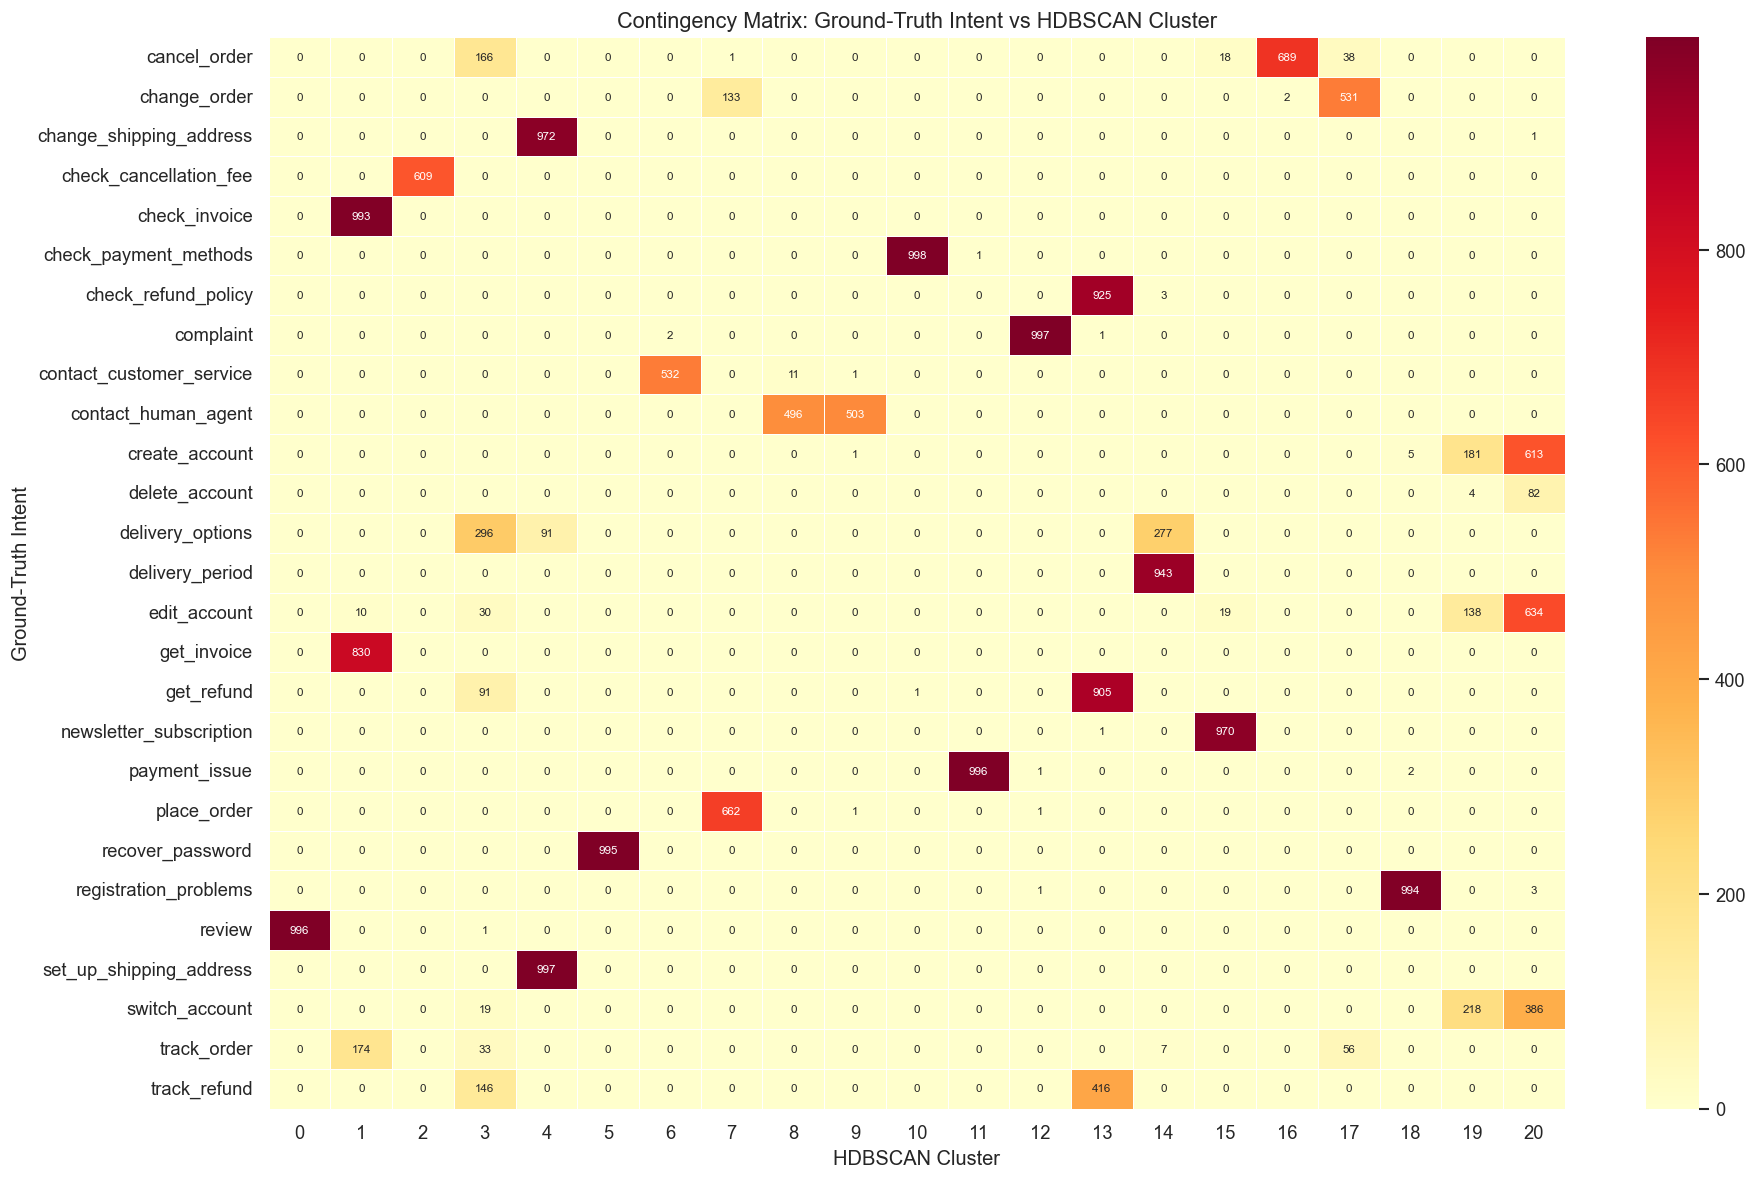

In [16]:
# Contingency matrix: Intent vs HDBSCAN Cluster
ct_intent = pd.crosstab(df.loc[valid_mask, "intent"], df.loc[valid_mask, "hdbscan_cluster"])

fig, ax = plt.subplots(figsize=(max(16, len(ct_intent.columns) * 0.6), 10))
sns.heatmap(ct_intent, annot=True, fmt="d", cmap="YlOrRd", ax=ax,
            linewidths=0.3, annot_kws={"size": 7})
ax.set_title("Contingency Matrix: Ground-Truth Intent vs HDBSCAN Cluster", fontsize=13)
ax.set_xlabel("HDBSCAN Cluster")
ax.set_ylabel("Ground-Truth Intent")
plt.tight_layout()
plt.show()

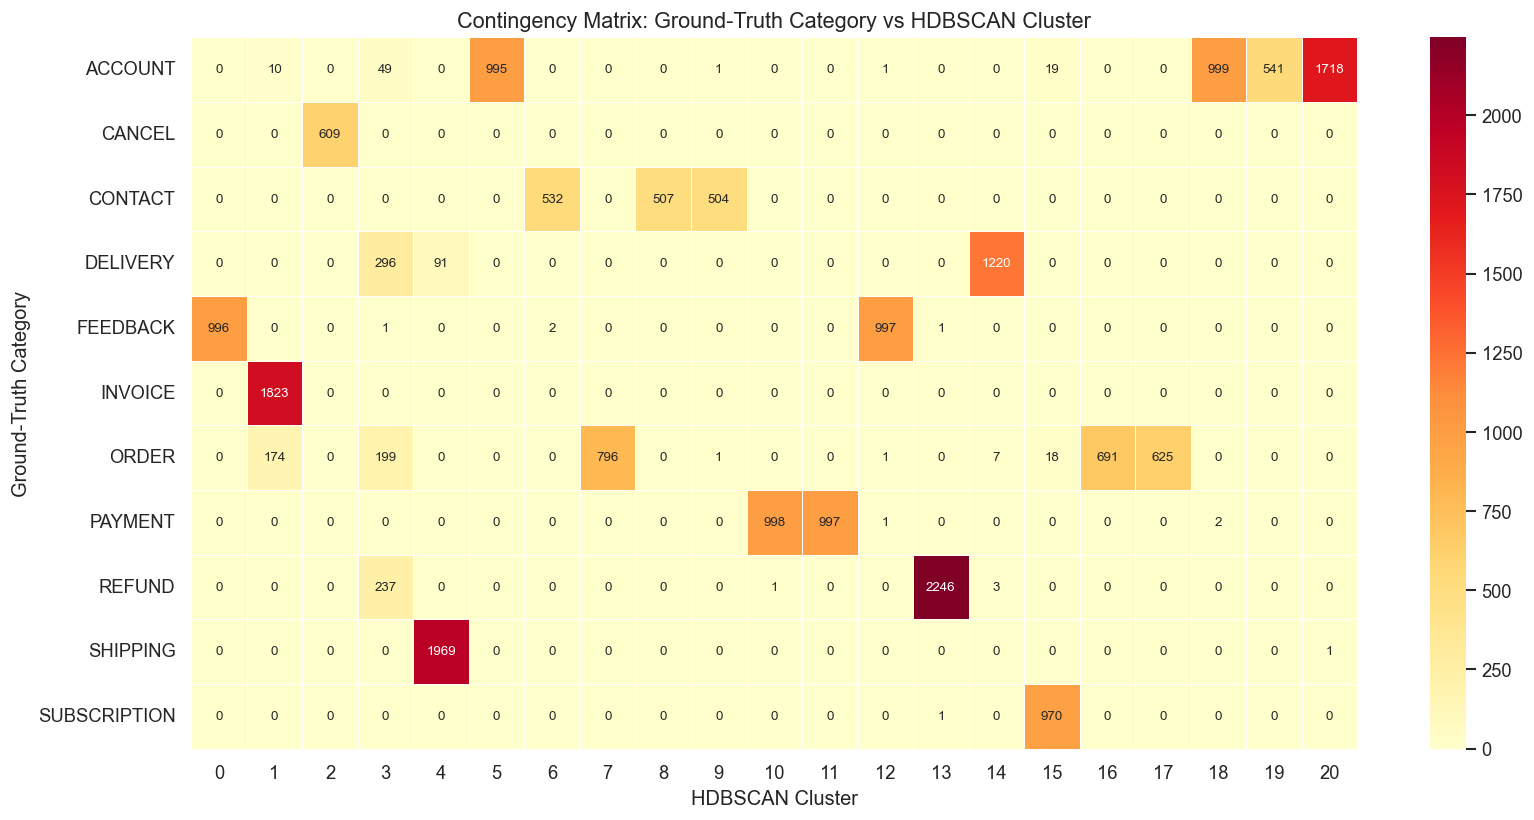

In [17]:
# Contingency matrix: Category vs HDBSCAN Cluster
ct_category = pd.crosstab(df.loc[valid_mask, "category"], df.loc[valid_mask, "hdbscan_cluster"])

fig, ax = plt.subplots(figsize=(max(14, len(ct_category.columns) * 0.6), 7))
sns.heatmap(ct_category, annot=True, fmt="d", cmap="YlOrRd", ax=ax,
            linewidths=0.3, annot_kws={"size": 8})
ax.set_title("Contingency Matrix: Ground-Truth Category vs HDBSCAN Cluster", fontsize=13)
ax.set_xlabel("HDBSCAN Cluster")
ax.set_ylabel("Ground-Truth Category")
plt.tight_layout()
plt.show()

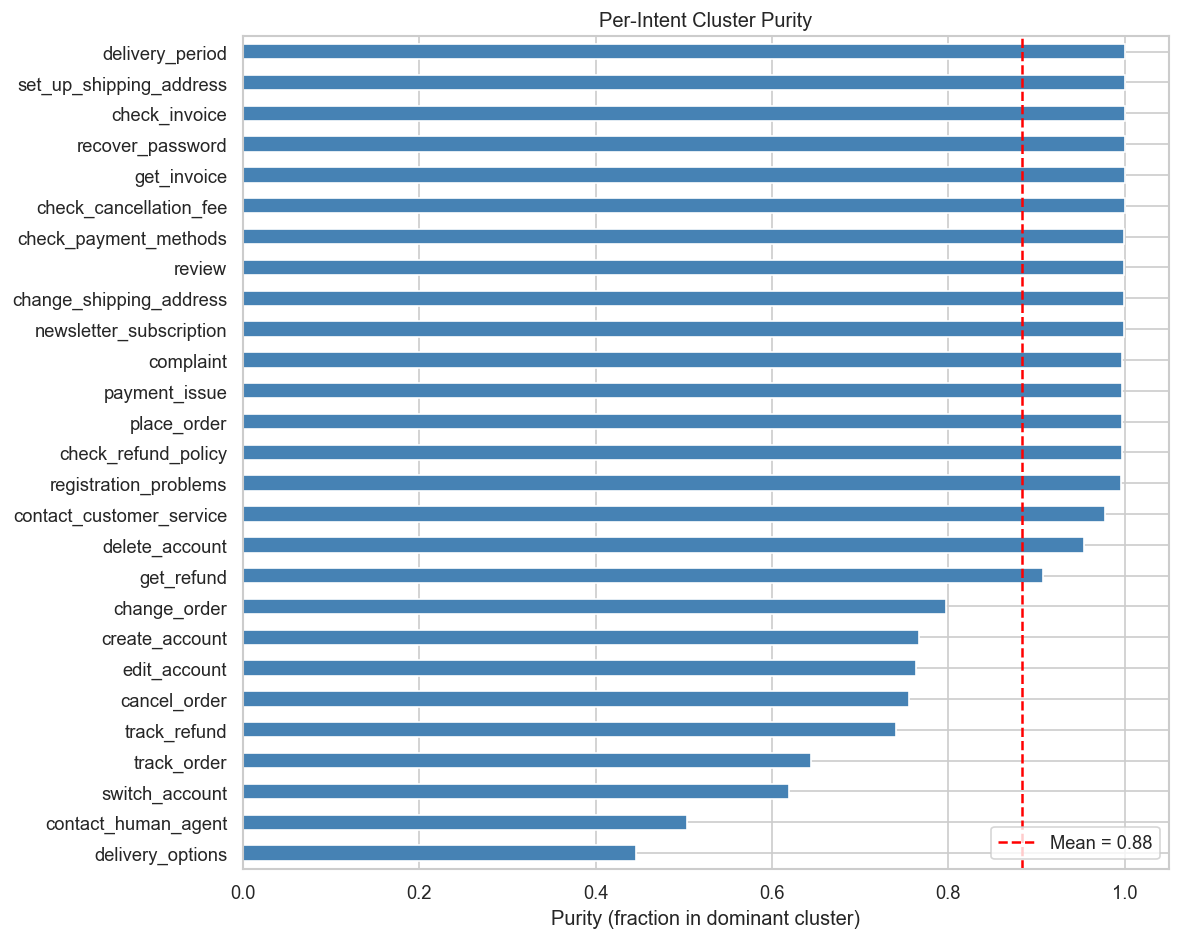


Purity stats: mean=0.883, min=0.446, max=1.000


In [18]:
# Per-intent cluster purity
# For each ground-truth intent, what fraction of its (non-noise) samples
# ended up in the single most common cluster?

purity_per_intent = {}
for intent in df.loc[valid_mask, "intent"].unique():
    mask = (df["intent"] == intent) & valid_mask
    cluster_counts = df.loc[mask, "hdbscan_cluster"].value_counts()
    purity_per_intent[intent] = cluster_counts.iloc[0] / cluster_counts.sum()

purity_series = pd.Series(purity_per_intent).sort_values()

fig, ax = plt.subplots(figsize=(10, 8))
purity_series.plot.barh(ax=ax, color="steelblue")
ax.axvline(x=purity_series.mean(), color="red", linestyle="--",
           label=f"Mean = {purity_series.mean():.2f}")
ax.set_xlabel("Purity (fraction in dominant cluster)")
ax.set_title("Per-Intent Cluster Purity")
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nPurity stats: mean={purity_series.mean():.3f}, "
      f"min={purity_series.min():.3f}, max={purity_series.max():.3f}")

## 9. Post-Hoc Cluster Labeling via TF-IDF

For each cluster, concatenate all instructions into a single "document", then compute TF-IDF.  
The **top-5 terms** (including bigrams) give a deterministic, interpretable label for each cluster.

In [19]:
valid_df = df[df["hdbscan_cluster"] != -1].copy()

# One "document" per cluster
cluster_docs = valid_df.groupby("hdbscan_cluster")["instruction"].apply(" ".join)

tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    ngram_range=(1, 2)
)
tfidf_matrix = tfidf.fit_transform(cluster_docs)
feature_names = tfidf.get_feature_names_out()

# Extract top terms per cluster
cluster_labels_tfidf = {}
print(f"{'Cluster':>8}  {'Top-5 TF-IDF Terms'}")
print("-" * 70)
for idx, cluster_id in enumerate(cluster_docs.index):
    row = tfidf_matrix[idx].toarray().flatten()
    top_indices = row.argsort()[-5:][::-1]
    top_terms = [feature_names[i] for i in top_indices]
    cluster_labels_tfidf[cluster_id] = ", ".join(top_terms)
    print(f"{cluster_id:>8}  {', '.join(top_terms)}")

 Cluster  Top-5 TF-IDF Terms
----------------------------------------------------------------------
       0  feedback, leave, send, send feedback, comment
       1  person, invoice, look, 37777, download
       2  early, exit, withdrawal, early exit, cancellation
       3  refund, delivery, country, delivery country, order
       4  address, shipping address, delivery address, delivery, shipping
       5  pin, key, user, reset, retrieve
       6  customer, customer support, customer service, support, customer assistance
       7  order, item, product, acquire, earn
       8  agent, operator, live, human agent, live agent
       9  somebody, assistant, speak, person, talk
      10  payment, payment options, payment methods, methods, modalities
      11  payment, payments, online, inform, report
      12  claim, complaint, consumer, reclamation, file
      13  money, ask, cases, refund, request
      14  arrive, soon, soon expect, expect, shipment
      15  newsletter, subscription, com

In [20]:
# Summary table: cluster TF-IDF label + dominant ground-truth intent
summary_rows = []
for cluster_id in sorted(valid_df["hdbscan_cluster"].unique()):
    mask = valid_df["hdbscan_cluster"] == cluster_id
    size = mask.sum()
    intent_counts = valid_df.loc[mask, "intent"].value_counts()
    dominant_intent = intent_counts.index[0]
    dominant_pct = intent_counts.iloc[0] / size * 100
    dominant_category = valid_df.loc[mask, "category"].value_counts().index[0]
    tfidf_label = cluster_labels_tfidf[cluster_id]
    summary_rows.append({
        "cluster": cluster_id,
        "size": size,
        "tfidf_label": tfidf_label,
        "dominant_intent": dominant_intent,
        "intent_pct": dominant_pct,
        "dominant_category": dominant_category
    })

summary_df = (
    pd.DataFrame(summary_rows)
    .sort_values("intent_pct", ascending=False)
    .reset_index(drop=True)
)
summary_df["intent_pct"] = summary_df["intent_pct"].map("{:.1f}%".format)
summary_df

,cluster,size,tfidf_label,dominant_intent,intent_pct,dominant_category
0,0,996,"feedback, leave, send, send feedback, comment",review,100.0%,FEEDBACK
1,5,995,"pin, key, user, reset, retrieve",recover_password,100.0%,ACCOUNT
2,2,609,"early, exit, withdrawal, early exit, cancellation",check_cancellation_fee,100.0%,CANCEL
3,10,999,"payment, payment options, payment methods, met...",check_payment_methods,99.9%,PAYMENT
4,11,997,"payment, payments, online, inform, report",payment_issue,99.9%,PAYMENT
5,16,691,"order, order number, number, cancel, purchase ...",cancel_order,99.7%,ORDER
6,12,1000,"claim, complaint, consumer, reclamation, file",complaint,99.7%,FEEDBACK
7,6,534,"customer, customer support, customer service, ...",contact_customer_service,99.6%,CONTACT
8,9,506,"somebody, assistant, speak, person, talk",contact_human_agent,99.4%,CONTACT
9,18,1001,"signup, sign, inform, notify, registration",registration_problems,99.3%,ACCOUNT


In [ ]:
# Annotated UMAP plot with TF-IDF labels at cluster centroids
fig, ax = plt.subplots(figsize=(18, 12))

umap_scatter(df, "hdbscan_cluster", ax, palette_hdb, noise_labels=-1)

# Annotate centroids with TF-IDF top term
for cid in non_noise:
    mask = df["hdbscan_cluster"] == cid
    cx = df.loc[mask, "umap_x"].mean()
    cy = df.loc[mask, "umap_y"].mean()
    short_label = cluster_labels_tfidf[cid].split(",")[0].strip()
    ax.annotate(
        f"C{cid}: {short_label}",
        (cx, cy), fontsize=7, ha="center", weight="bold",
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="grey", alpha=0.85)
    )

ax.set_title("UMAP 2D — HDBSCAN Clusters with TF-IDF Labels", fontsize=14)
plt.tight_layout()
plt.show()

## 10. (Optional) LLM-Based Cluster Labeling

An alternative to TF-IDF: sample representative instructions from each cluster (closest to centroid) and prompt an LLM to generate a descriptive label.

> **Note:** This section requires an API key. The code below constructs prompts and prints them. Uncomment the API call lines to run live.

In [ ]:
from dotenv import load_dotenv
import anthropic
import asyncio

load_dotenv()


def get_representative_samples(df, cluster_id, embeddings, n=8):
    """Return the n instructions closest to the cluster centroid (cosine distance)."""
    mask = (df["hdbscan_cluster"] == cluster_id).values
    cluster_embs = embeddings[mask]
    centroid = cluster_embs.mean(axis=0)
    # Cosine distance: 1 - cos_sim
    norms_emb = np.linalg.norm(cluster_embs, axis=1)
    norm_cent = np.linalg.norm(centroid)
    cosine_dists = 1 - (cluster_embs @ centroid) / (norms_emb * norm_cent + 1e-10)
    closest_idx = cosine_dists.argsort()[:n]
    return df.loc[mask, "instruction"].iloc[closest_idx].tolist()


async def label_cluster(async_client, cid, samples, tfidf_label):
    """Label a single cluster via the Anthropic API."""
    prompt = (
        "Below are representative customer support utterances from a single cluster.\n"
        "Generate a short (2\u20135 word) descriptive label for this cluster.\n"
        "Reply with ONLY the label, nothing else.\n\n"
        "Utterances:\n"
        + "\n".join(f"- {s}" for s in samples)
        + "\n\nLabel:"
    )
    response = await async_client.messages.create(
        model="claude-sonnet-4-5-20250929",
        max_tokens=30,
        messages=[{"role": "user", "content": prompt}],
    )
    label = response.content[0].text.strip()
    print(f"  Cluster {cid:>2} (TF-IDF: {tfidf_label:<12s}) -> LLM: {label}")
    return cid, label


async def label_all_clusters():
    """Label all clusters concurrently."""
    async_client = anthropic.AsyncAnthropic()
    tasks = []
    for cid in sorted(valid_df["hdbscan_cluster"].unique()):
        samples = get_representative_samples(df, cid, embeddings)
        tfidf_label = cluster_labels_tfidf[cid].split(",")[0].strip()
        tasks.append(label_cluster(async_client, cid, samples, tfidf_label))
    results = await asyncio.gather(*tasks)
    return dict(results)


print("Labeling clusters with LLM (concurrent)...\n")
llm_labels = await label_all_clusters()

# Add LLM labels to summary_df
summary_df["llm_label"] = summary_df["cluster"].map(llm_labels)
print()
summary_df

## 11. Summary & Key Findings

In [ ]:
print("=" * 65)
print("  CLUSTERING ANALYSIS SUMMARY")
print("=" * 65)
print(f"  Embedding model:           {MODEL_NAME}")
print(f"  Embedding dimensions:      {embeddings.shape[1]}")
print(f"  UMAP cluster dims:         {embeddings_umap_cluster.shape[1]}")
print(f"  HDBSCAN min_cluster_size:  {best_mcs}")
print(f"  HDBSCAN min_samples:       {best_ms}")
print(f"  HDBSCAN epsilon:           {best_eps}")
print(f"  HDBSCAN clusters found:    {n_clusters}")
print(f"  Noise points:              {n_noise:,} ({n_noise / len(df) * 100:.1f}%)")
print(f"  DBCV:                      {clusterer.relative_validity_:.4f}")
print(f"  \u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500")
print(f"  {'Metric':<30} {'Excl. Noise':>12} {'Full Dataset':>13}")
print(f"  \u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500")
print(f"  {'ARI vs Intent (27)':<30} {ari_intent:>12.4f} {ari_intent_full:>13.4f}")
print(f"  {'NMI vs Intent (27)':<30} {nmi_intent:>12.4f} {nmi_intent_full:>13.4f}")
print(f"  {'ARI vs Category (11)':<30} {ari_category:>12.4f} {ari_category_full:>13.4f}")
print(f"  {'NMI vs Category (11)':<30} {nmi_category:>12.4f} {nmi_category_full:>13.4f}")
print(f"  \u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500")
print(f"  Mean per-intent purity:    {purity_series.mean():.3f}")
print(f"  Min per-intent purity:     {purity_series.min():.3f}")
print("=" * 65)